# Imports

In [35]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image
import tifffile
# !pip install imagecodecs
import imagecodecs
import cv2

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays
from numpy import asarray

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras import metrics
from tensorflow.keras import backend as K

#Data Loading

In [17]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# !unzip drive/My\ Drive/DL_Project/ultrasound-nerve-segmentation.zip -d drive/My\ Drive/DL_Project/ 

In [19]:
# Data loading 

path = ''
image_train_path = os.path.join(path, 'drive/MyDrive/DL_Project/train/')

image_dataset = os.listdir(image_train_path)
image_list = []
mask_list = []
image_dataset.sort()
for file in image_dataset:
    if file.endswith('_mask.tif'):
        mask_list.append(file)
        image_list.append(file.replace("_mask.tif",".tif"))    


## Showing samples

(420, 580)
(420, 580)


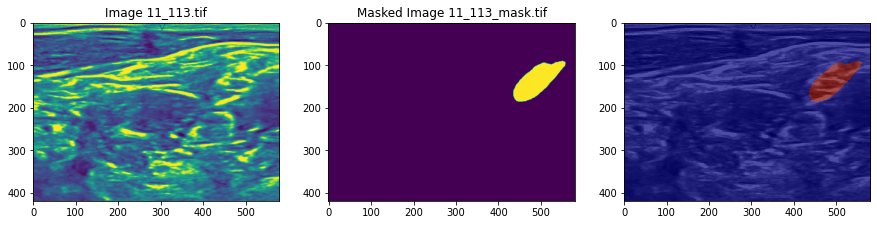

In [20]:
N = 134
img = imageio.imread(image_train_path + image_list[N])
mask = imageio.imread(image_train_path + mask_list[N])

print(img.shape)
print(mask.shape)

fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img)
arr[0].set_title('Image ' + image_list[N])
arr[1].imshow(mask)
arr[1].set_title('Masked Image '+ mask_list[N])

arr[2].imshow(img, cmap = 'gray', interpolation = 'none')
arr[2].imshow(mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

#Preprocessing

In [21]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

      # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        
        single_mask_ind = mask[index]
        path = os.path.join(path1, single_mask_ind)
        single_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask/255
        single_mask = single_mask.astype(int) 
        y[index] = single_mask
    return X, y


In [22]:
def visualize_output(display_list, title,image_index = 0):
  # Visualize the output
  
  fig, arr = plt.subplots(1, len(display_list), figsize=(15, 15))
  for i in range(len(display_list)):
    display_img = display_list[i][image_index]
    if (np.array(display_list[i]).shape[-1] < 3):
      display_img = display_list[i][image_index,:,:,0]
    arr[i].imshow(display_img)
    arr[i].set_title(title[i])

In [23]:
from matplotlib.axis import YAxis
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function

X, y = PreprocessData(image_list, mask_list, target_shape_img, target_shape_mask, image_train_path, image_train_path)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes
print(np.unique(y))



X Shape: (5635, 128, 128, 3)
Y shape: (5635, 128, 128, 1)
[0 1]


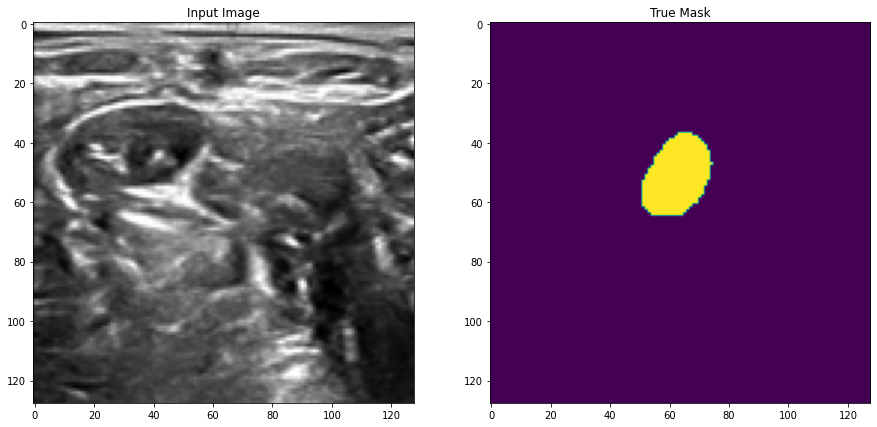

In [24]:
# Visualize the output
title = ['Input Image', 'True Mask']
visualize_output([X,y], title,50)

#UNET

##Encoder

In [25]:
def EncoderBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """

    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    
    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

##Decoder

In [26]:
def DecoderBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

        # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

## UNET Architecture

In [27]:
def UNet(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    convblock1 = EncoderBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    convblock2 = EncoderBlock(convblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    convblock3 = EncoderBlock(convblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    convblock4 = EncoderBlock(convblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    convblock5 = EncoderBlock(convblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderBlock(convblock5[0], convblock4[1],  n_filters * 8)
    ublock7 = DecoderBlock(ublock6, convblock3[1],  n_filters * 4)
    ublock8 = DecoderBlock(ublock7, convblock2[1],  n_filters * 2)
    ublock9 = DecoderBlock(ublock8, convblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

#Train the Model

##Split the Data

In [28]:
# 80% training, 20% validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)


## Model Compiling

In [29]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNet(input_size=(128,128,3), n_filters=32, n_classes=2)

# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

###Loss Function

In [38]:

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer = optimizer, 
             loss=loss,
              metrics=[
                      # metrics.SensitivityAtSpecificity,
                      # metrics.SpecificityAtSensitivity,
                      # metrics.Accuracy(),
                      # metrics.AUC(),
                      # dice_coef,
                      # jacard,
                      # 'accuracy' 
                      tf.keras.metrics.TruePositives()
                      ]
)

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


In [ ]:
plt.plot(results.history["loss"])
plt.title("Training Loss vs. Epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(results.history["accuracy"])
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Prediction

##Show Predictions for Training data



In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [ ]:
def show_predictions(X, y,image_index):
    """
    Displays the image, true mask and predicted mask of the trainig dataset
    """
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    pred_mask = unet.predict(X[5:10])
    visualize_output([X, y, create_mask(pred_mask)], title,image_index)
    

In [ ]:
for i in range(5,10):
  show_predictions(X, y,i)

## Load Test data

In [ ]:
## predict test set
path2 = 'drive/MyDrive/DL_Project/test/'
image_test_dataset = os.listdir(path2)
test_img = []
for file in image_test_dataset:
    test_img.append(file)

## Predict Mask for Testing data

In [ ]:
# create a table with X and Y

m = len(test_img)                     # number of images
i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image

# Define X and Y as number of images along with shape of one image
test_X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)

# Resize images and masks
for file in test_img:
    # convert image into an array of desired shape (3 channels)
    index = test_img.index(file)
    path = os.path.join(path2, file)
    single_img = Image.open(path).convert('RGB')
    single_img = single_img.resize((i_h,i_w))
    single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
    single_img = single_img/256.
    test_X[index] = single_img

# predict masks
test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)

In [ ]:
# visualize test imge with created mask 
title = ["Test Image", "Predicted Mask"]
visualize_output([test_X, test_y], title ,150)